In [26]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict
from IPython.display import display, HTML
custom_colors = ["#9C27B0", "#2196F3", "#4CAF50", "#F44336", "#9E9E9E"]


In [27]:
df = pd.read_csv('all_tags_fin.csv', sep=';', encoding='cp1251')

In [28]:
df = df.rename(columns={"Item Type": "Publication Type"})
df['Manual Tags'] = df['Manual Tags'].apply(lambda x: [tag.strip() for tag in x.split(';')] if isinstance(x, str) else [])
df['Publication Type'] = df['Publication Type'].replace('bookSection', 'Book Section').replace('conferencePaper', 'Conference Paper').replace('journalArticle', 'Journal Article')

In [29]:
df[["Publication Type","Publication Year","Publication Title","Author","Title","Manual Tags"]].head()

,Publication Type,Publication Year,Publication Title,Author,Title,Manual Tags
0,Journal Article,2023,arXiv.org,Quanjun Zhang; Tongke Zhang; Jun Zhai; Chunrong Fang; Bo Yu; Weisong Sun; Zhenyu Chen,A Critical Review of Large Language Model on Software Engineering: An Example from ChatGPT and Automated Program Repair,"[1. LLM, 1.1. Transformer-based Models, 1.2. Multimodal Models, 1.3. Fine-tuned / Instruction-tuned, 4. Software Engineering, 4.1. Development Task Automation, 4.1.2. Code Repair / Refactoring, 5. Prompt Engineering, 5.1. Prompting Strategies]"
1,Journal Article,2022,Information & Software Technology,"Khaliq, Zubair; Khaliq, Zubair; Farooq, Sheikh Umar; Farooq, Sheikh Umar; Khan, Dawood Ashraf; Khan, Dawood Ashraf",A Deep Learning-based automated framework for functional User Interface testing,"[2. ML, 2.2. Deep Learning, 2.2.1. CNN / RNN / LSTM, 3. Software Testing, 3.1. Test Automation, 3.1.1. Test Generation, 3.1.4. Test Repair, 3.2. Test Data Generation, 3.2.1. Test Oracle, 3.2.3. Test Datasets (HTML, Screenshots, UML), 3.3. Functional Testing]"
2,Conference Paper,2024,International Conference on Engineering of Computer-Based Systems,"Taromirad, Masoumeh; Runeson, Per",A literature survey of assertions in software testing,"[3. Software Testing, 3.1. Test Automation, 3.1.1. Test Generation, 3.1.6. Failure Detection, 3.2. Test Data Generation, 3.2.1. Test Oracle, 3.3. Functional Testing, 3.5. Robustness / Non-functional Testing]"
3,Journal Article,2023,ACM Transactions on Software Engineering and Methodology,"Belgacem, Hichem; Li, Xiaochen; Bianculli, Domenico; Briand, Lionel",A Machine Learning Approach for Automated Filling of Categorical Fields in Data Entry Forms,"[2. ML, 2.1. Traditional Machine Learning, 4. Software Engineering, 4.1. Development Task Automation]"
4,Journal Article,2024,arXiv.org,"Ricca, Filippo; Marchetto, Alessandro; Marchetto, A.; Stocco, Andrea",A multi-year grey literature review on AI-assisted test automation,"[1. LLM, 1.1. Transformer-based Models, 1.3. Fine-tuned / Instruction-tuned, 2. ML, 2.2. Deep Learning, 2.2.1. CNN / RNN / LSTM, 2.5. Reinforcement Learning Strategies, 3. Software Testing, 3.1. Test Automation, 3.1.1. Test Generation, 3.1.2. Test Optimization, 3.1.4. Test Repair, 3.2. Test Data Generation, 3.2.1. Test Oracle]"


In [30]:
year_item_counts = df.groupby(['Publication Year', 'Publication Type']).size().unstack(fill_value=0)


year_item_counts_adjusted = year_item_counts.copy()


if 2025 in year_item_counts_adjusted.index:
    days_passed = 125 
    year_item_counts_adjusted.loc[2025] = np.round(
        year_item_counts_adjusted.loc[2025] * 365 / days_passed
    )

print(year_item_counts_adjusted)

Publication Type  Book Section  Conference Paper  Journal Article
Publication Year                                                 
2021                         1                 8                6
2022                         1                 0                5
2023                         0                 2               30
2024                         0                14               61
2025                         0                 9               76


In [31]:
def get_openalex_citations(doi):
    if pd.isna(doi):
        return np.nan
    url = f"https://api.openalex.org/works/https://doi.org/{doi}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        time.sleep(0.5) 
        return data.get('cited_by_count', np.nan)
    except requests.exceptions.RequestException as e:
        print(f"Error: {doi} → {e}")
        return np.nan


tqdm.pandas()


df['CitationCount'] = df.apply(
    lambda row: get_openalex_citations(row['DOI']) if (pd.isna(row['CitationCount']) or row['CitationCount'] == '') else row['CitationCount'],
    axis=1
)


In [32]:
df.to_csv("data_with_citations_NEW.csv", index=False)


In [33]:
df['DOI'].isna().sum()


33

In [34]:
df['CitationCount'].isna().sum()


0

In [35]:
pd.set_option('display.max_colwidth', None)
df[["Author","Title","Publication Year","CitationCount"]].head(10)

,Author,Title,Publication Year,CitationCount
0,Quanjun Zhang; Tongke Zhang; Jun Zhai; Chunrong Fang; Bo Yu; Weisong Sun; Zhenyu Chen,A Critical Review of Large Language Model on Software Engineering: An Example from ChatGPT and Automated Program Repair,2023,19.0
1,"Khaliq, Zubair; Khaliq, Zubair; Farooq, Sheikh Umar; Farooq, Sheikh Umar; Khan, Dawood Ashraf; Khan, Dawood Ashraf",A Deep Learning-based automated framework for functional User Interface testing,2022,11.0
2,"Taromirad, Masoumeh; Runeson, Per",A literature survey of assertions in software testing,2024,6.0
3,"Belgacem, Hichem; Li, Xiaochen; Bianculli, Domenico; Briand, Lionel",A Machine Learning Approach for Automated Filling of Categorical Fields in Data Entry Forms,2023,14.0
4,"Ricca, Filippo; Marchetto, Alessandro; Marchetto, A.; Stocco, Andrea",A multi-year grey literature review on AI-assisted test automation,2024,1.0
5,"Naimi, Lahbib; Bouziane, El Mahi; Manaouch, Mohamed; Jakim, Abdeslam",A new approach for automatic test case generation from use case diagram using LLMs and prompt engineering,2024,0.0
6,"Sun, J.; Wang, J.; Zhu, Y.; Li, X.; Xie, Y.; Chen, J.",A Noval Approach to Automated Test Script Generation using Large Language Models for Domain-Specific Language,2024,0.0
7,"Chang, Xiaoning; Liang, Zheheng; Zhang, Yifei; Cui, Lei; Long, Zhenyue; Wu, Guoquan; Gao, Yu; Chen, Wei; Wei, Jun; Huang, Tao",A reinforcement learning approach to generating test cases for web applications,2023,8.0
8,"Pham, Phuoc; Nguyen, Vu; Nguyen, Tien N.",A review of AI-augmented end-to-end test automation tools,2022,8.0
9,"Wang, Qing; Wang, Junjie; Li, Mingyang; Wang, Yawen; Liu, Zhe",A roadmap for software testing in open-collaborative and AI-powered era,2024,0.0


In [36]:
top = 10
title = "Publication Title"

df[title].value_counts().head(top)


Publication Title
ACM Transactions on Software Engineering and Methodology                                       7
International Conference on Automated Software Engineering                                     6
arXiv.org                                                                                      5
International Conference on Software Testing, Verification and Validation Workshops            5
Proceedings of the 39th IEEE/ACM International Conference on Automated Software Engineering    4
International Conference on Software Engineering                                               4
Information and Software Technology                                                            4
International Symposium on Software Testing and Analysis                                       3
International Conference on Software Quality, Reliability and Security                         3
Proc. ACM Softw. Eng.                                                                          3
Name: count,

In [37]:
exploded_df = df.explode('Manual Tags')
exploded_df = exploded_df[exploded_df['Manual Tags'].notna()]
exploded_df = exploded_df[exploded_df['Manual Tags'].astype(str).str.strip() != '']
tag_counts_by_year = exploded_df.groupby(['Publication Year', 'Manual Tags']).size().unstack(fill_value=0)
tag_counts_by_year_adjusted = tag_counts_by_year.copy()
if 2025 in tag_counts_by_year_adjusted.index:
    tag_counts_by_year_adjusted.loc[2025] = np.round(
        tag_counts_by_year_adjusted.loc[2025] * 365 / 125
    )
all_years = pd.DataFrame(index=range(2021, 2026))
tag_counts_by_year_adjusted = all_years.join(
    tag_counts_by_year_adjusted, how='left'
).fillna(0)


In [38]:
exploded_df = df.explode('Manual Tags')
tag_counts_by_year = exploded_df.groupby(['Publication Year', 'Manual Tags']).size().unstack(fill_value=0)
tag_counts_by_year_adjusted = tag_counts_by_year.copy()

In [39]:
if 2025 in tag_counts_by_year_adjusted.index:
    tag_counts_by_year_adjusted.loc[2025] = np.round(
        tag_counts_by_year_adjusted.loc[2025] * 365 / 125
    )
all_years = pd.DataFrame(index=range(2021, 2026))  
tag_counts_by_year_adjusted = all_years.join(
    tag_counts_by_year_adjusted, how='left'
).fillna(0)

C:\Users\DK00747\AppData\Local\Temp\ipykernel_16832\2351338187.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  '1': cm.get_cmap('Greens'),
C:\Users\DK00747\AppData\Local\Temp\ipykernel_16832\2351338187.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  '2': cm.get_cmap('Blues'),
C:\Users\DK00747\AppData\Local\Temp\ipykernel_16832\2351338187.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  '3': cm.get_cmap('Reds'),
C:\Users\DK00747\AppData\Local\Temp\i

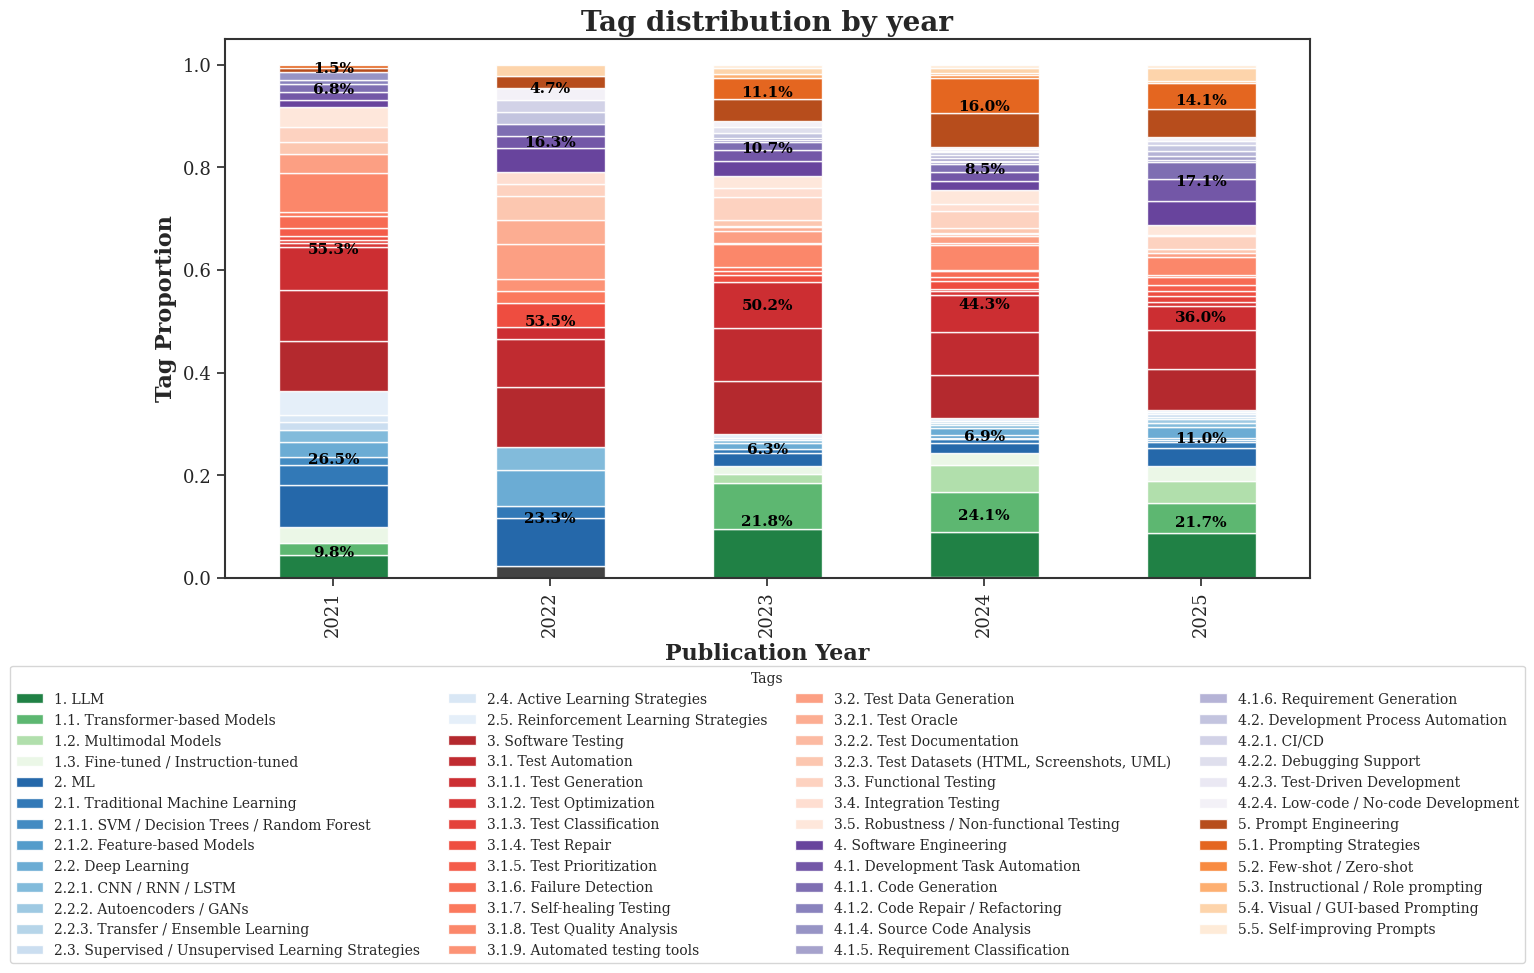

In [40]:
all_tag_counts_by_year = tag_counts_by_year_adjusted.copy()
tag_proportions_by_year = all_tag_counts_by_year.div(all_tag_counts_by_year.sum(axis=1), axis=0)
tag_families = {}
for tag in tag_proportions_by_year.columns:
    if tag.startswith("1."):
        tag_families[tag] = '1'
    elif tag.startswith("2."):
        tag_families[tag] = '2'
    elif tag.startswith("3."):
        tag_families[tag] = '3'
    elif tag.startswith("4."):
        tag_families[tag] = '4'
    elif tag.startswith("5."):
        tag_families[tag] = '5'
    else:
        tag_families[tag] = 'other'
family_cmaps = {
    '1': cm.get_cmap('Greens'),
    '2': cm.get_cmap('Blues'),
    '3': cm.get_cmap('Reds'),
    '4': cm.get_cmap('Purples'),
    '5': cm.get_cmap('Oranges'),
    'other': cm.get_cmap('Greys')
}
category_labels = ['1', '2', '3', '4', '5']
category_proportions_by_year = pd.DataFrame(index=tag_proportions_by_year.index)

for category in category_labels:
    matching_cols = [col for col in tag_proportions_by_year.columns if col.startswith(category + '.')]
    category_proportions_by_year[category] = tag_proportions_by_year[matching_cols].sum(axis=1)
family_to_tags = defaultdict(list)
for tag, fam in tag_families.items():
    family_to_tags[fam].append(tag)
tag_colors = {}
for fam, tags in family_to_tags.items():
    cmap = family_cmaps[fam]
    for i, tag in enumerate(sorted(tags)):
        norm_i = 0.85 - (0.75 * i / max(len(tags) - 1, 1)) 
        tag_colors[tag] = cmap(norm_i)

colors = [tag_colors[tag] for tag in tag_proportions_by_year.columns]
plt.figure(figsize=(14, 7))
tag_proportions_by_year.plot(kind='bar', stacked=True, color=colors, alpha=0.9, ax=plt.gca())

ax = plt.gca()

for i, year in enumerate(category_proportions_by_year.index):
    y_offset = 0
    for category in category_labels:
        proportion = category_proportions_by_year.loc[year, category]
        if proportion > 0.01:
            y_center = y_offset + proportion / 2
            ax.text(
                i, y_center,
                f"{proportion * 100:.1f}%",
                ha='center', va='center',
                fontsize=11,
                color='black',
                weight='bold'
            )
        y_offset += proportion

plt.title("Tag distribution by year", fontsize=20, fontweight='bold')
plt.xlabel("Publication Year", fontsize=16, fontweight='bold')
plt.ylabel("Tag Proportion", fontsize=16, fontweight='bold')
plt.xticks(ticks=range(len(tag_proportions_by_year.index)), labels=tag_proportions_by_year.index)

plt.legend(
    title='Tags',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    fontsize='small',
    title_fontsize='small'
)

plt.grid(False)
#plt.tight_layout()
plt.show()


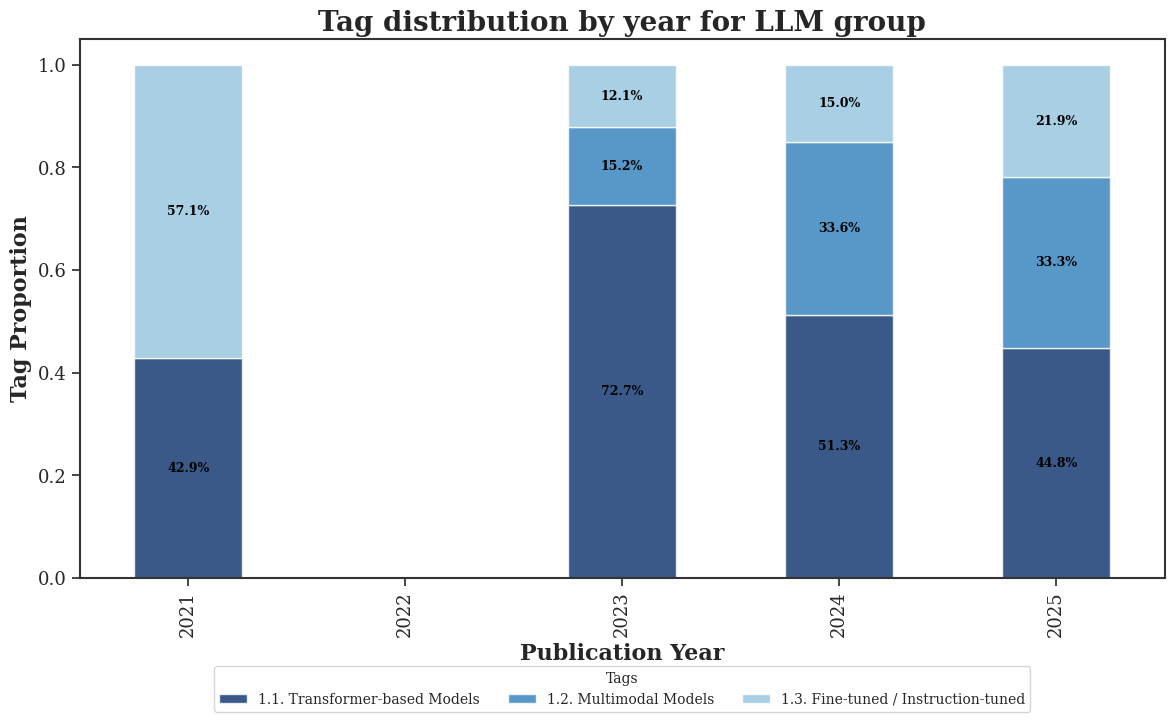

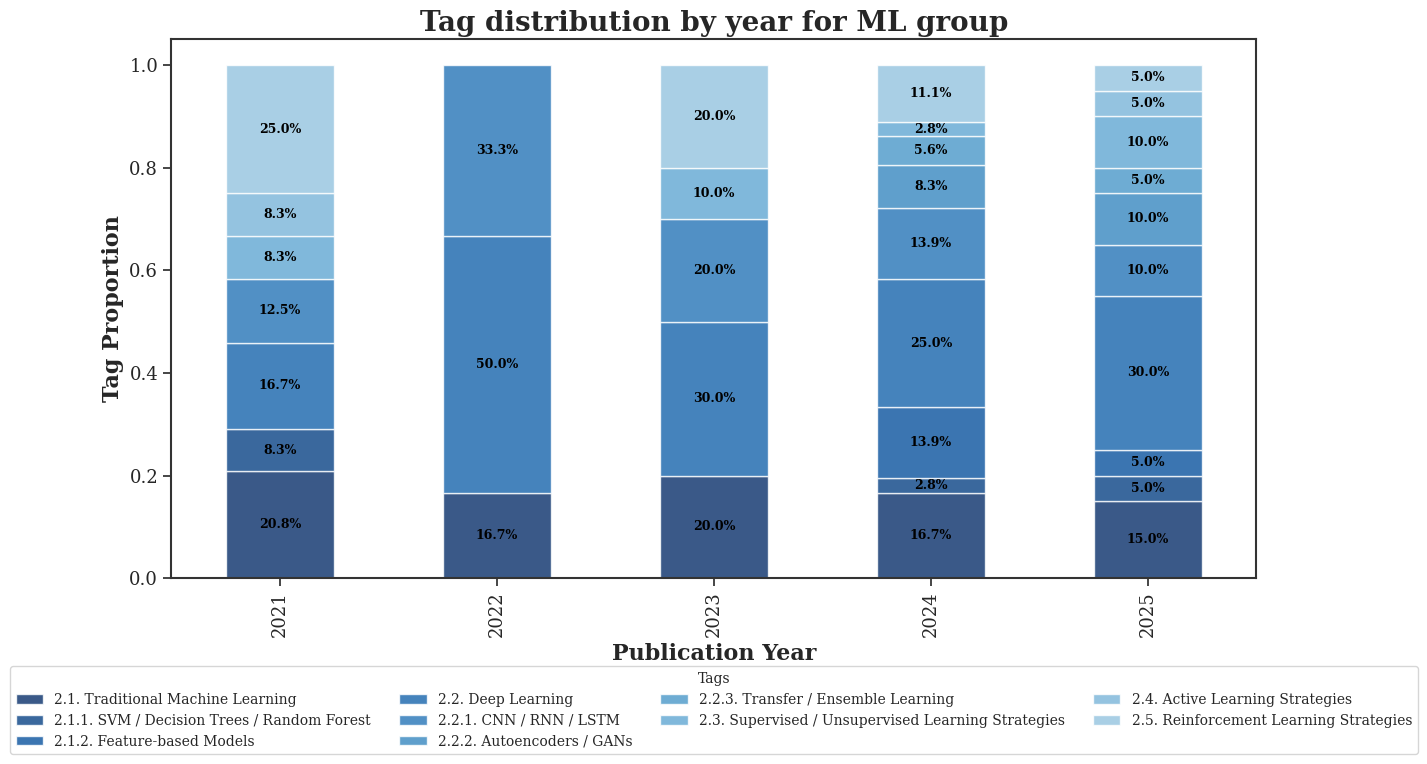

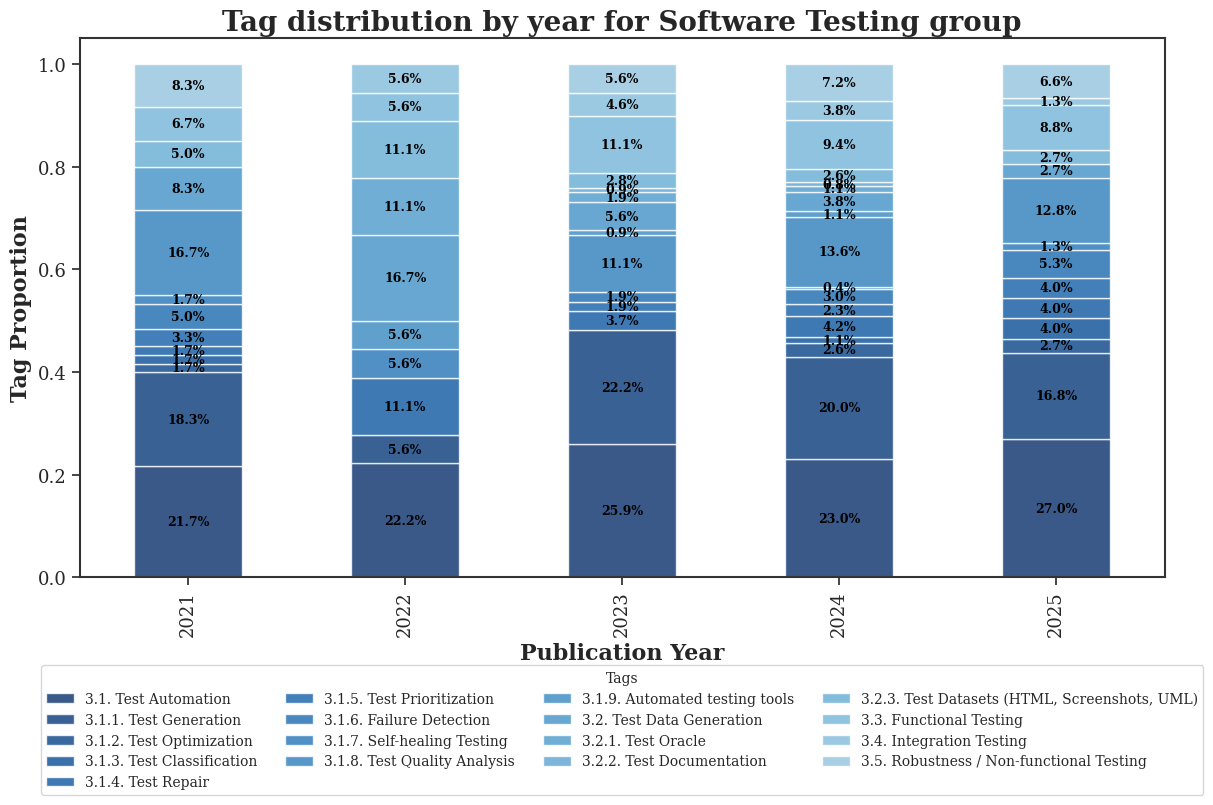

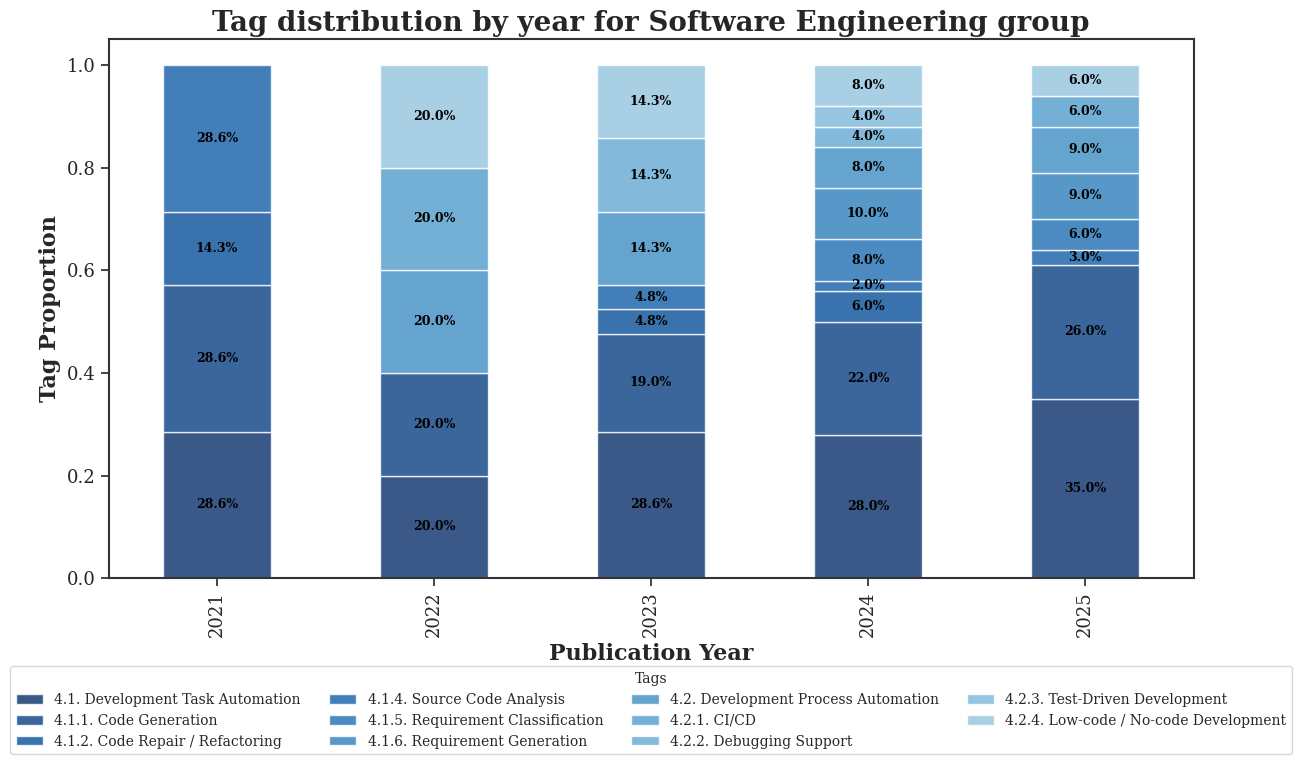

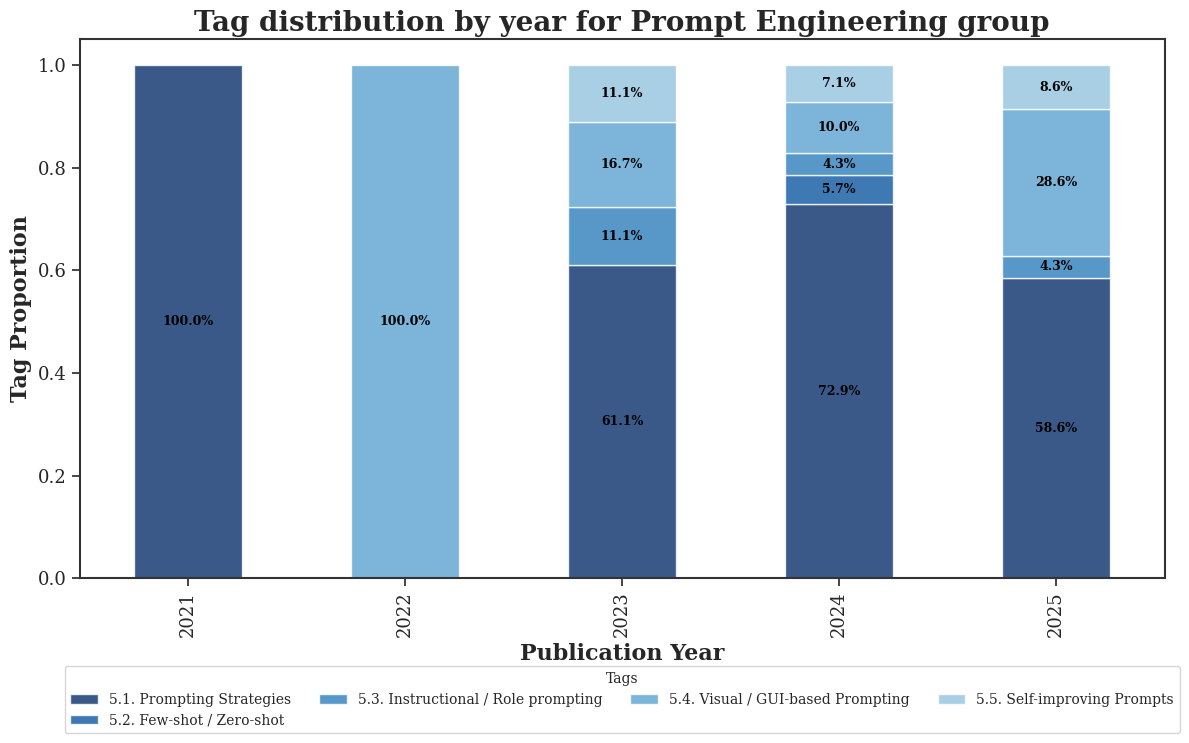

In [41]:
top_groups = {
    'LLM': '1.',
    'ML': '2.',
    'Software Testing': '3.',
    'Software Engineering': '4.',
    'Prompt Engineering': '5.',
}

for group_name, prefix in top_groups.items():
    top_tag = f"{prefix} {group_name}"
    group_tags = [
        col for col in tag_counts_by_year_adjusted.columns 
        if col.startswith(prefix) and col.strip() != top_tag
    ]
    if not group_tags:
        continue
    group_df = tag_counts_by_year_adjusted[group_tags]
    group_df = group_df.div(group_df.sum(axis=1), axis=0)
    num_tags = len(group_df.columns)
    cmap = plt.get_cmap('Blues')
    colors = [cmap(1.0 - 0.6 * i / max(num_tags - 1, 1)) for i in range(num_tags)]

    plt.figure(figsize=(14, 7))
    ax = plt.gca()
    group_df.plot(
        kind='bar',
        stacked=True,
        color=colors,
        alpha=0.8,
        ax=ax
    )

    for i, year in enumerate(group_df.index):
        y_offset = 0
        for tag, color in zip(group_df.columns, colors):
            value = group_df.loc[year, tag]
            if value > 0:
                ax.text(
                    i, y_offset + value / 2,
                    f"{value * 100:.1f}%",
                    ha='center', va='center',
                    fontsize=9,
                    color='black',
                    weight='bold'
                )
            y_offset += value

    plt.title(f"Tag distribution by year for {group_name} group", fontsize=20, fontweight='bold')
    plt.xlabel("Publication Year", fontsize=16, fontweight='bold')
    plt.ylabel("Tag Proportion", fontsize=16, fontweight='bold')
    plt.xticks(ticks=range(len(group_df.index)), labels=group_df.index, fontsize=13)
    plt.yticks(fontsize=13)
    
    plt.legend(
        title='Tags',
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=4,
        fontsize='small',
        title_fontsize='small'
    )

    plt.grid(False)
    #plt.tight_layout()
    plt.show()



In [42]:
df['tag_list'] = df['Manual Tags'].apply(lambda x: x if isinstance(x, list) else [])
exploded = df.explode('tag_list')
exploded['tag_list'] = exploded['tag_list'].astype(str).str.strip()

tag_sums_all = (
    exploded.drop_duplicates(subset=['Title', 'tag_list'])
            .groupby('tag_list')
            .size()
            .sort_index()
)
def extract_numeric_prefix(tag):
    try:
        parts = tag.split(' ')[0].split('.')
        return tuple(int(p) for p in parts if p.isdigit())
    except:
        return (float('inf'),)

tag_sums_sorted = tag_sums_all.iloc[
    sorted(range(len(tag_sums_all)), key=lambda i: extract_numeric_prefix(tag_sums_all.index[i]))
]

pd.set_option('display.max_rows', None)
print(tag_sums_sorted)


tag_list
                                                        2
1. LLM                                                121
1.1. Transformer-based Models                         101
1.2. Multimodal Models                                 55
1.3. Fine-tuned / Instruction-tuned                    33
2. ML                                                  47
2.1. Traditional Machine Learning                      17
2.1.1. SVM / Decision Trees / Random Forest             4
2.1.2. Feature-based Models                             6
2.2. Deep Learning                                     25
2.2.1. CNN / RNN / LSTM                                14
2.2.2. Autoencoders / GANs                              5
2.2.3. Transfer / Ensemble Learning                     3
2.3. Supervised / Unsupervised Learning Strategies      6
2.4. Active Learning Strategies                         3
2.5. Reinforcement Learning Strategies                 13
3. Software Testing                                   130
3.1. 

In [43]:
pd.set_option('display.max_colwidth', None)

In [44]:
df['Manual Tags'] = df['Manual Tags'].astype(str)

In [45]:
import pandas as pd
from IPython.display import display, HTML

df_tags = tag_sums_sorted.reset_index()
df_tags.columns = ['Tag', 'Count']
df_tags = df_tags[df_tags['Tag'] != ''].reset_index(drop=True)

mid = (len(df_tags) + 1) // 2
first_half = df_tags.iloc[:mid].reset_index(drop=True)
second_half = df_tags.iloc[mid:].reset_index(drop=True)
max_len = max(len(first_half), len(second_half))
first_half = first_half.reindex(range(max_len)).fillna('')
second_half = second_half.reindex(range(max_len)).fillna('')

df_pretty = pd.DataFrame({
    'Tag 1': first_half['Tag'],
    'Count 1': first_half['Count'],
    'Tag 2': second_half['Tag'],
    'Count 2': second_half['Count'],
})

df_pretty['Count 1'] = df_pretty['Count 1'].apply(lambda x: int(x) if isinstance(x, (int, float)) and x == int(x) else x)
df_pretty['Count 2'] = df_pretty['Count 2'].apply(lambda x: int(x) if isinstance(x, (int, float)) and x == int(x) else x)

styled = df_pretty.style.set_properties(
    subset=['Tag 1', 'Tag 2'], 
    **{'text-align': 'left'}
).set_table_styles(
    [
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('vertical-align', 'top')]}
    ]
)

display(HTML(styled.to_html(index=False)))

,Tag 1,Count 1,Tag 2,Count 2
0,1. LLM,121,3.2. Test Data Generation,26
1,1.1. Transformer-based Models,101,3.2.1. Test Oracle,7
2,1.2. Multimodal Models,55,3.2.2. Test Documentation,3
3,1.3. Fine-tuned / Instruction-tuned,33,"3.2.3. Test Datasets (HTML, Screenshots, UML)",17
4,2. ML,47,3.3. Functional Testing,49
5,2.1. Traditional Machine Learning,17,3.4. Integration Testing,17
6,2.1.1. SVM / Decision Trees / Random Forest,4,3.5. Robustness / Non-functional Testing,35
7,2.1.2. Feature-based Models,6,4. Software Engineering,38
8,2.2. Deep Learning,25,4.1. Development Task Automation,35
9,2.2.1. CNN / RNN / LSTM,14,4.1.1. Code Generation,27


In [46]:
sns.set_theme(
    style="ticks",
    palette="muted",
    rc={
        "figure.figsize": (12, 6),  
        "axes.titlesize": 20,       
        "axes.titleweight": "bold", 
        "axes.labelsize": 16,       
        "axes.labelweight": "bold",         
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "xtick.major.width": 1.2,   
        "ytick.major.width": 1.2,   
        "axes.linewidth": 1.5,
        "legend.fontsize": 14,
        "legend.title_fontsize": 15,
        "axes.edgecolor": "#333333",        
        "font.family": "serif",        
    }
)

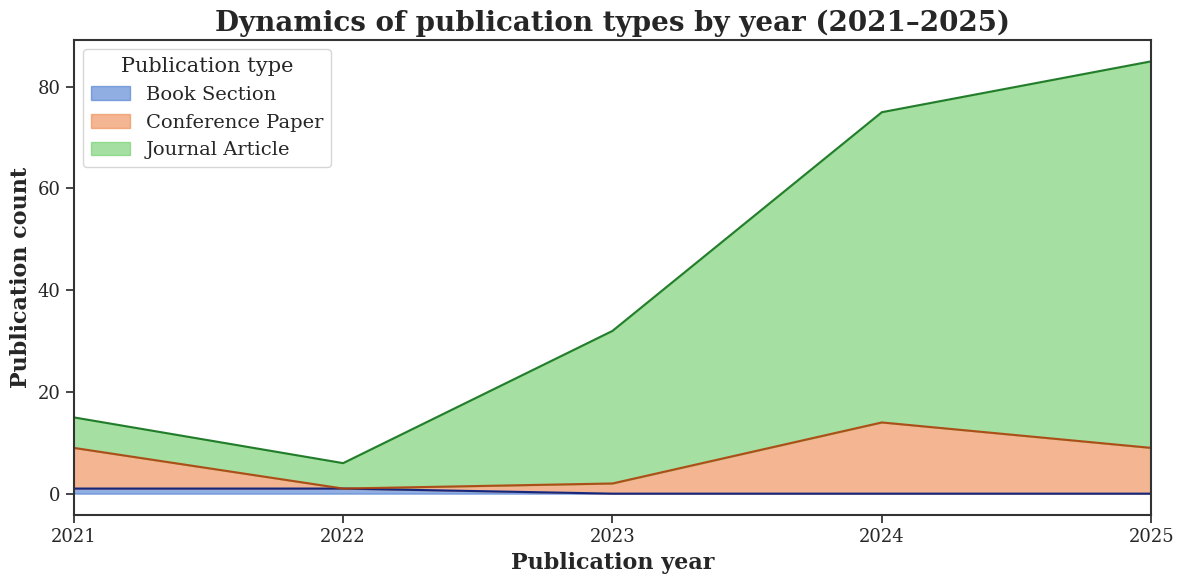

In [47]:
cumsum_data = year_item_counts_adjusted.cumsum(axis=1)
prev = np.zeros_like(year_item_counts_adjusted.iloc[:, 0])
base_colors = sns.color_palette("muted", n_colors=year_item_counts_adjusted.shape[1])
highlight_colors = sns.color_palette("dark", n_colors=year_item_counts_adjusted.shape[1])
years = year_item_counts_adjusted.index
plt.figure(figsize=(12, 6))
for i, column in enumerate(year_item_counts_adjusted.columns):
    values = year_item_counts_adjusted[column].values
    top = prev + values    
    plt.fill_between(
        years, prev, top,
        color=base_colors[i],
        alpha=0.6,
        label=column
    )
    plt.plot(
        years, top,
        color=highlight_colors[i],
        linewidth=1.5,
        alpha=0.9
    )
    prev = top

plt.xlabel('Publication year')
plt.ylabel('Publication count')
plt.title("Dynamics of publication types by year (2021–2025)")
plt.xlim(2021, 2024)
plt.xticks(range(2021, 2026, 1))
plt.legend(title='Publication type')
plt.tight_layout()
plt.show()


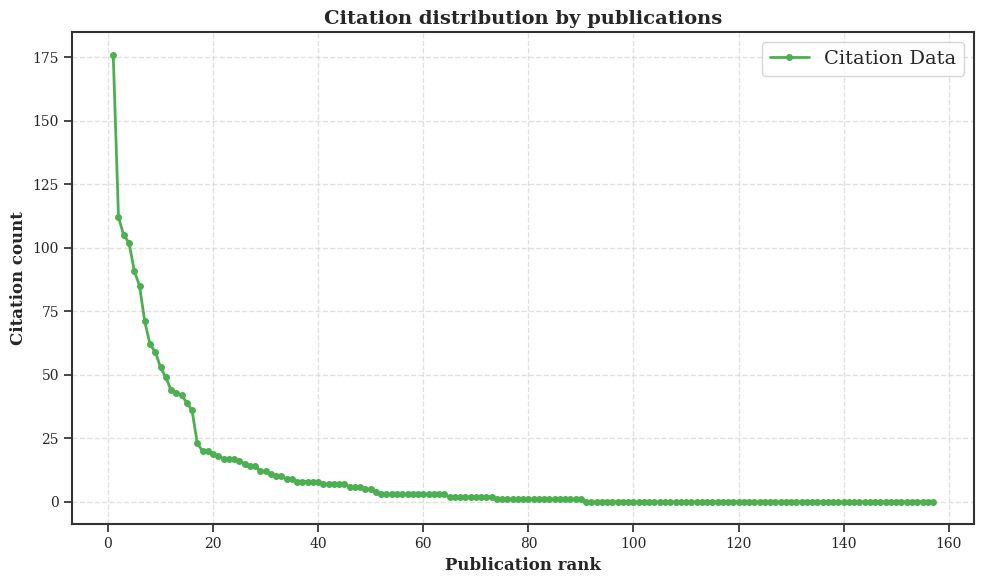

In [48]:
df = df.sort_values(by="CitationCount", ascending=False)
df['Rank'] = range(1, len(df) + 1)
top_n = 157
df_top = df.head(top_n)

plt.figure(figsize=(10, 6))
plt.plot(
    df_top['Rank'],
    df_top['CitationCount'],
    marker='o',
    markersize=4,
    linewidth=2,
    color='#4CAF50',
    label='Citation Data'
)

plt.title("Citation distribution by publications", fontsize=14, weight='bold')
plt.xlabel("Publication rank", fontsize=12)
plt.ylabel("Citation count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


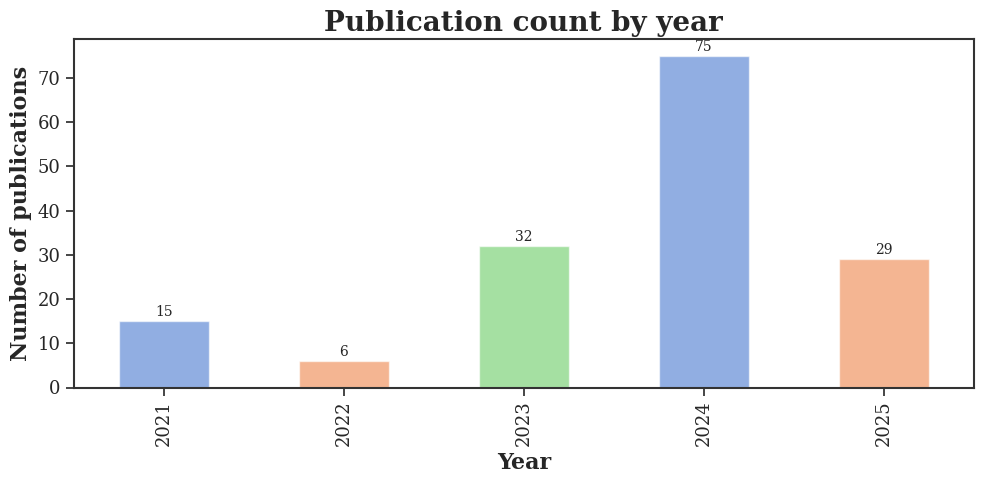

In [49]:
counts = df.groupby('Publication Year')['Title'].count()
base_colors = sns.color_palette("muted", n_colors=year_item_counts_adjusted.shape[1])
ax = counts.plot(
    kind='bar',
    figsize=(10, 5),
    color=base_colors,
    alpha=0.6,
    title='Publication count by year'
)

for i, value in enumerate(counts):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.xlabel('Year')
plt.ylabel('Number of publications')
plt.tight_layout()
plt.show()

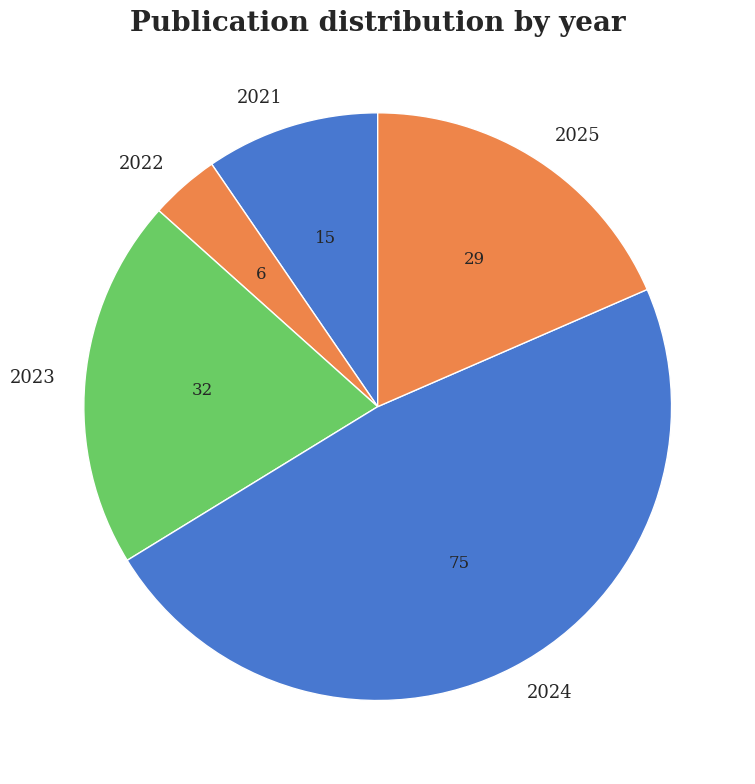

In [50]:
base_colors = sns.color_palette("muted", n_colors=year_item_counts_adjusted.shape[1])
counts = df.groupby(['Publication Year'])['Title'].count()

def absolute_value(val):
    total = sum(counts)
    absolute = int(round(val / 100 * total))
    return f"{absolute}"

plt.figure(figsize=(8, 8))
counts.plot(
    kind='pie',
    colors=base_colors,
    autopct=absolute_value,
    startangle=90,
    legend=False
)

plt.title('Publication distribution by year')
plt.ylabel('')
plt.tight_layout()
plt.show()
